In [11]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.data_processing import AA_KEYS, compute_pfm, compute_ic_position, compute_ic, get_mia
from src.utils import pkl_dump, pkl_load
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140
import warnings
warnings.filterwarnings("ignore")
from tqdm.autonotebook import tqdm
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)
DATADIR = '../output_xls/filtered_rank20/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
for l in range(8,13):
    for hla in hlas:
        files = [os.path.join(DATADIR,x) for x in os.listdir(DATADIR) if hla in x and f'{l}mer' in x]
        df = pd.concat([pd.read_csv(x, sep = '\t', skiprows=1,header=0) for x in files])
        df1 = df.query('EL_Rank<0.25')
        df1= df1.drop(index=df1.loc[df1['Peptide'].apply(lambda x: any([z not in AA_KEYS for z in x]))].index)
        if len(df1)==0:
            print(l,hla)
        # df5 = df.query('EL_Rank<0.5')
        # drop_idx5 = df5.loc[df5['Peptide'].apply(lambda x: any([z not in AA_KEYS for z in x]))].index
        # print(f'1: len\t{l}\t{hla}\t{len(df1.drop(index=drop_idx1).Peptide.values)}') 
        # print(f'5: len\t{l}\t{hla}\t{len(df5.drop(index=drop_idx5).Peptide.values)}')

KeyboardInterrupt: 

In [ ]:
# Parallelize
from joblib import Parallel, delayed
from functools import partial
import multiprocessing
def get_anchors_ics(hla, length,
                    ranks = [0.1, 0.25, 0.5], DATADIR='../output_xls/filtered_rank20/',
                    how='shannon', seq_weighting=False, beta=100):
    files = [os.path.join(DATADIR, x) for x in os.listdir(DATADIR) if hla in x and f'{length}mer' in x]
    if len(files)==0:
        return 0
    df = pd.concat([pd.read_csv(x, sep = '\t', skiprows=1, header=0) for x in files])
    res = {}
    res['hla'] = hla
    res['l'] = length
    for k in ranks:
        tmp = df.query('EL_Rank < @k')
       
        drop_idx = tmp.loc[tmp['Peptide'].apply(lambda x: any([z not in AA_KEYS for z in x]))].index
        seqs = tmp.drop(index=drop_idx).Peptide.values
        if len(seqs)==0:
            print(hla, length, k)
        res[k] = compute_ic(seqs, how, seq_weighting, beta)
    return res

hlas = np.unique([x.split('_')[0] for x in os.listdir(DATADIR) if 'chunk' in x and x.endswith('rank20.txt')])
lens = list(range(8,13))
for how in tqdm(['shannon', 'kl'], desc='how', leave=True):
    res = {}
    for l in tqdm(lens, desc='len', leave=True):
        res[l] = {}
        get_anchors_ics_ = partial(get_anchors_ics, length=l,
                                   ranks=[0.2, 0.25, 0.5], how=how,
                                   seq_weighting=False)
        output = Parallel(n_jobs=8)(delayed(get_anchors_ics_)(hla) for hla in hlas)
        for item in output:
            res[l][item['hla']]={}
            res[l][item['hla']][0.15] = item[0.15]
            res[l][item['hla']][0.25] = item[0.25]
            res[l][item['hla']][0.5] = item[0.5]
    pkl_dump(res, f'ics_{how}.pkl', '../output') 

In [22]:
cedar_aligned_expr = pd.read_csv('../data/pepx/230308_cedar_aligned_pepx_fold.csv')
prime_aligned_expr = pd.read_csv('../data/pepx/230308_prime_aligned_pepx.csv')

ics_len = pkl_load('../data/ic_dicts/ics_len.pkl')
cedar_aligned_expr['npeps_ics_025'] = cedar_aligned_expr.apply(lambda x: ics_len[x['icore_len_mut']][x['HLA']][0.25],axis=1)
cedar_aligned_expr['npeps_ics_05'] = cedar_aligned_expr.apply(lambda x: ics_len[x['icore_len_mut']][x['HLA']][0.5],axis=1)

prime_aligned_expr['npeps_ics_025'] = prime_aligned_expr.apply(lambda x: ics_len[x['icore_len_mut']][x['HLA']][0.25],axis=1)
prime_aligned_expr['npeps_ics_05'] = prime_aligned_expr.apply(lambda x: ics_len[x['icore_len_mut']][x['HLA']][0.5],axis=1)

In [24]:
cedar_aligned_expr.query('npeps_ics_025<=200')[['Peptide', 'icore_len_mut', 'HLA', 'agg_label', 'EL_rank_mut','npeps_ics_025', 'npeps_ics_05']]

,Peptide,icore_len_mut,HLA,agg_label,EL_rank_mut,npeps_ics_025,npeps_ics_05
393,EYVPRFVFK,8,HLA-A1101,0,1.8574,79,747
630,FTGQFVSEEV,8,HLA-A0206,0,3.6341,59,610
648,FVRTNSLVFR,8,HLA-A1101,0,1.4790,79,747
1801,QDVSVQVER,8,HLA-A6801,1,0.7234,67,630
2083,RTQDVSVQVER,8,HLA-A6801,1,0.7234,67,630
2693,VQLIMQLMPF,8,HLA-A0206,0,8.3851,59,610
2723,VVSHPHLVYW,8,HLA-A6802,0,4.9251,38,271
2782,WTGATITVTIK,8,HLA-A1101,1,0.5743,79,747
2888,YMKSLEFENK,8,HLA-A1101,1,3.9345,79,747


In [25]:
prime_aligned_expr.query('npeps_ics_025<=200')[['Peptide', 'icore_len_mut', 'HLA', 'agg_label', 'EL_rank_mut','npeps_ics_025', 'npeps_ics_05']]

,Peptide,icore_len_mut,HLA,agg_label,EL_rank_mut,npeps_ics_025,npeps_ics_05
333,DVSVQVER,8,HLA-A6801,0,0.7234,67,630
336,EAALNNPKMY,8,HLA-A6801,0,3.3939,67,630
421,EWVPEPPER,8,HLA-A6801,0,2.5852,67,630
805,GSKRAVTK,8,HLA-A1101,0,4.5046,79,747
1065,IYCVLLTFLK,8,HLA-A1101,0,4.1537,79,747
1077,KAGECGLK,8,HLA-A1101,0,9.2938,79,747
1101,KIFIEWLK,8,HLA-A1101,0,1.7612,79,747
1225,KTLTIPFKNSY,8,HLA-A1101,0,0.6572,79,747
1318,LGVVESAK,8,HLA-A1101,0,22.7222,79,747
1438,LMCGTWYKVK,8,HLA-A1101,0,4.8631,79,747


In [26]:
len(cedar_aligned_expr.query('npeps_ics_025<=200')), len(prime_aligned_expr.query('npeps_ics_025<=200')), 

(9, 27)

<AxesSubplot:ylabel='Frequency'>

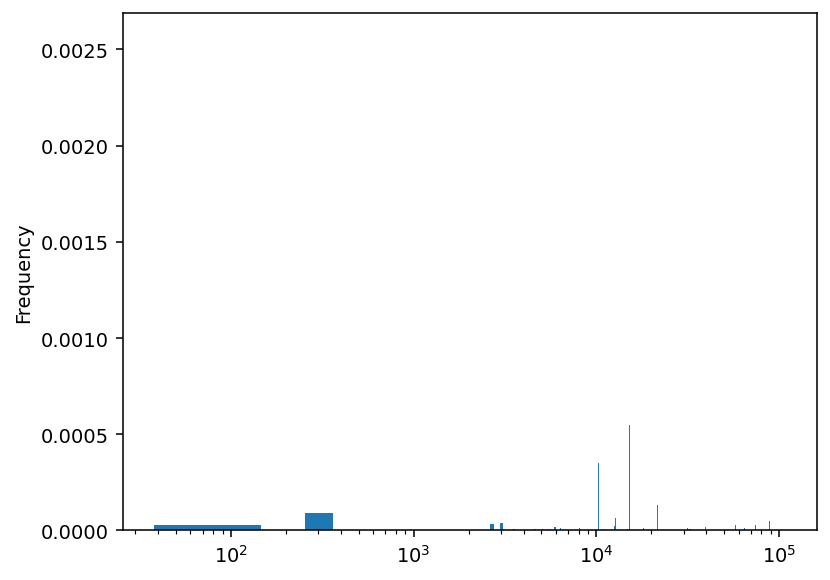

In [31]:
cedar_aligned_expr['npeps_ics_025'].plot(kind='hist', density=True, bins=1000,logx=True)